<a href="https://colab.research.google.com/github/GabrielYYM/Notebooks/blob/main/ComparacaoCogumelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

RANDOM_STATE = 42

## Load and prepare data


In [ ]:
datasets = ['Odor.csv','Habitat.csv','Lamela.csv','Cor.csv','Chapeu.csv', "Impressao.csv"] # Excluded "TodasCaracteristicas.csv"

results = {}

for dataset_path in datasets:

    df = pd.read_csv(dataset_path)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )

    results[dataset_path] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }

print(results.keys())

dict_keys(['Odor.csv', 'Habitat.csv', 'Lamela.csv', 'Cor.csv', 'Chapeu.csv', 'Impressao.csv'])


## Train and evaluate model

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

results_chi2 = {}

for dataset_path, data in results.items():
    X_train = data['X_train']
    X_test = data['X_test']
    y_train = data['y_train']
    y_test = data['y_test']

    # Perform chi-squared feature selection for the current dataset
    # Setting k to 'all' selects all features
    selector_chi2 = SelectKBest(score_func=chi2, k='all')
    X_train_selected = selector_chi2.fit_transform(X_train, y_train)
    X_test_selected = selector_chi2.transform(X_test)


    svm_model = SVC(random_state=RANDOM_STATE)
    svm_model.fit(X_train_selected, y_train)

    y_pred = svm_model.predict(X_test_selected)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label='p')
    recall = recall_score(y_test, y_pred, pos_label='p')

    results_chi2[dataset_path] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall
    }

print("Results after Chi-squared Feature Selection:")
for dataset_path, data in results_chi2.items():
    print(f"Dataset: {dataset_path}")
    print(f"  Accuracy: {data['accuracy']:.4f}")
    print(f"  Precision: {data['precision']:.4f}")
    print(f"  Recall: {data['recall']:.4f}")

Results after Chi-squared Feature Selection:
Dataset: Odor.csv
  Accuracy: 0.9858
  Precision: 1.0000
  Recall: 0.9706
Dataset: Habitat.csv
  Accuracy: 0.7028
  Precision: 0.8049
  Recall: 0.5057
Dataset: Lamela.csv
  Accuracy: 0.7735
  Precision: 0.8908
  Recall: 0.6041
Dataset: Cor.csv
  Accuracy: 0.5988
  Precision: 0.6123
  Recall: 0.4559
Dataset: Chapeu.csv
  Accuracy: 0.7157
  Precision: 0.7257
  Recall: 0.6590
Dataset: Impressao.csv
  Accuracy: 0.8634
  Precision: 0.8484
  Recall: 0.8723
Dataset: TodasCaracteristicas.csv
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000


## Compare results


In [ ]:
metrics_list = []
for dataset_path, metrics in results.items():
    metrics_list.append({
        'Dataset': dataset_path,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall']
    })

metrics_df = pd.DataFrame(metrics_list)
display(metrics_df)

,Dataset,Accuracy,Precision,Recall
0,Odor.csv,0.985846,1.000000,0.970626
1,Habitat.csv,0.702769,0.804878,0.505747
2,Lamela.csv,0.773538,0.890772,0.604087
3,Cor.csv,0.598769,0.612350,0.455939
4,Chapeu.csv,0.715692,0.725738,0.659004
5,Impressao.csv,0.863385,0.848447,0.872286
6,TodasCaracteristicas.csv,1.000000,1.000000,1.000000


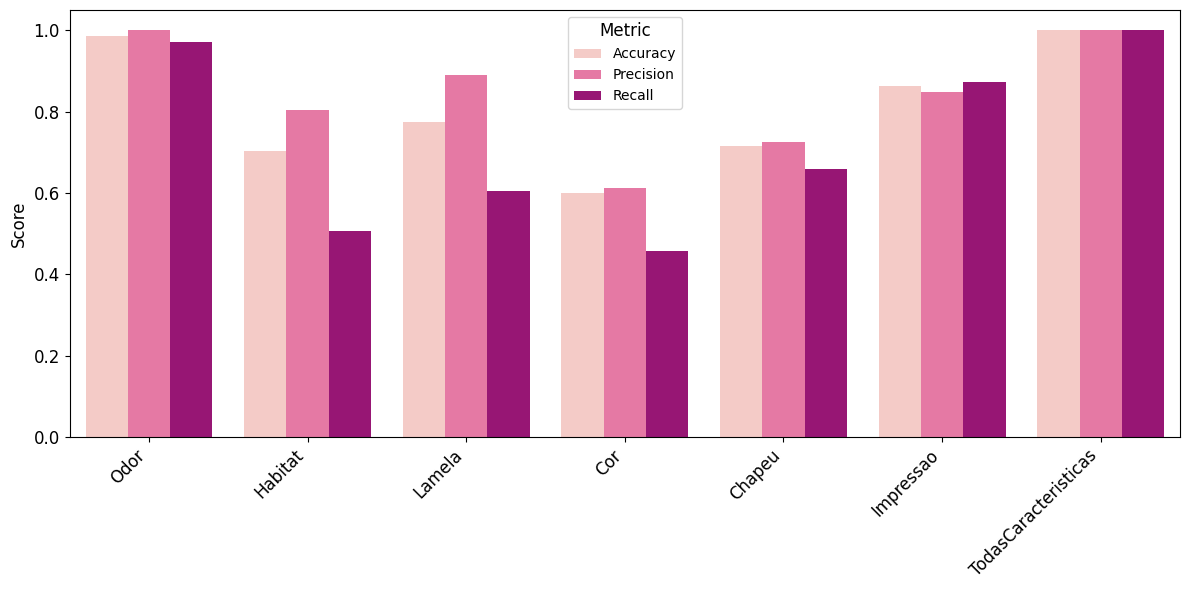

In [ ]:
# Melt the DataFrame to a long format for plotting
metrics_melted = metrics_df.melt(id_vars='Dataset', var_name='Metric', value_name='Score')

# Create a new column without the .csv extension
metrics_melted['Dataset_Name'] = metrics_melted['Dataset'].str.replace('.csv', '', regex=False)

# Use the 'RdPu' color palette
custom_palette = sns.color_palette('RdPu', n_colors=3)


# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Dataset_Name', y='Score', hue='Metric', data=metrics_melted, palette=custom_palette)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('') # Remove the x-axis label
plt.ylabel('Score', fontsize=12)
plt.legend(title='Metric', fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

all_features_scores = []

for dataset_path, data in results.items():
    X_train = data['X_train']
    y_train = data['y_train']

    # Perform chi-squared feature selection for the current dataset
    selector_chi2 = SelectKBest(score_func=chi2, k='all')
    selector_chi2.fit(X_train, y_train)
    scores = selector_chi2.scores_

    # Create a DataFrame for scores of the current dataset
    df_scores = pd.DataFrame({
        "Feature": X_train.columns,
        "Score": scores
    })

    # Add a column to indicate the dataset
    df_scores['Dataset'] = dataset_path.replace('.csv', '')

    all_features_scores.append(df_scores)

# Concatenate scores from all datasets
df_all_scores = pd.concat(all_features_scores, ignore_index=True)

# Scale the scores to be between 0 and 1 across all features from all datasets
scaler = MinMaxScaler()
df_all_scores['Score_Scaled'] = scaler.fit_transform(df_all_scores['Score'].values.reshape(-1, 1))

# Create combined feature names for plotting
df_all_scores['Feature_Dataset'] = df_all_scores['Feature'] + " (" + df_all_scores['Dataset'] + ")"

# Get the best feature for each dataset
df_best_features = df_all_scores.loc[df_all_scores.groupby('Dataset')['Score_Scaled'].idxmax()]

fig = px.scatter(
    df_best_features,
    x="Feature_Dataset",
    y="Score_Scaled",
    color="Score_Scaled",
    color_continuous_scale="Viridis",
)
fig.update_layout(
    xaxis_tickangle=-90,
    height=600, # Increased height for better readability
    margin=dict(l=50, r=50, t=80, b=200), # Increased bottom margin
    yaxis=dict(range=[0, 1]) # Set y-axis range from 0 to 1
)
fig.show()